In [ ]:
############################################################------MODELISATION 1-----####################################################################################################
#                                                                    
#                                                    Premiere Modelisation sur le jeu de données 
#                                                           - Heatmap
#                                                           - Préparation des données à la modélisation
#                                                           - Modélisation : - RandomForestClassifier
#                                                                            - Optimisation des hyperparametres
#                                                                            - Validation croisée
#                                                                            - Analyse des erreurs
#                                                                            - Interprétabilité                                                           
#                                                             
#############################################################################################################################################################################################

################################################ - IMPORTATION des bibliotheques - ##################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import ClusterCentroid
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

import lightgbm as lgb
from lightgbm import LGBMClassifier
import shap


################################################## - RECUPERATION de la base projet csv - ##################################

##################################################################################################################################################################
# # base pour la 1 er modelisation #
# df_modelisation1=df_base_apres_processing.drop(["Titre_commentaire","Commentaire","mots","mots_titre","class_note","Nombre_Émoticônes_Positives","Nombre_Émoticônes_Négatives"],axis=1)
# display(df_modelisation1.head())
# df_modelisation1.info()

# # # Export de la nouvelle base etape3 modelisation 1
# df_modelisation1.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\df3.projet_truspilot2_modelisation1.csv", index=False)
##############################################################################################################################################################################

df= pd.read_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\df3.projet_truspilot2_modelisation1.csv", sep=',')
display(df.head())
df.info()


In [39]:

#______________________________visualisation avec une heatmap__________________________________________________________

# var_num = df.select_dtypes(include = ['int','float'])
# #var_num=var_num.drop(["Nombre_avis_client","sentimentfr"], axis=1)

# #corrélations de toutes les variables quantitatives de df.
# cor = var_num.corr()
# print(cor)

# fig = plt.subplots(figsize = (10,6))
# sns.heatmap(cor, annot = True, cmap = "Spectral")
# plt.show()



In [ ]:
####################################### - PREPARATION A LA MODELISATION- #########################################################
###################################################################################################################################


# Séparation l'ensemble d'entraînement, de validation et de test
X = df.drop('Note_client',axis=1)
y = df['Note_client']


#Séparation des données en ensembles d'entraînement(80%), de validation(10%) et de test(10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

# Encodage indépendamment des 3 ensembles

X_numerique_train= X_train[["nbre_phrases"]]
X_numerique_test= X_test[["nbre_phrases"]]
X_numerique_val= X_val[["nbre_phrases"]]

#X_numerique = df_train[['nbre_mots',"nbre_phrases" ,'sentimentfr', 'Nombre_Émoticônes']]

# Encodage la variable cible avec labelEncoder (pour des variables ordinales)

le = LabelEncoder()
y_train= le.fit_transform(y_train)+1
y_test = le.transform(y_test)+1
y_val= le.transform(y_val)+1


#Encodage des autres variables categorielles

X_categorielle_train=X_train[['class_longueur_mot',"class_pt_exclam","emoticones","class_sentiment","class_nbavis"]]
X_categorielle_encoded_train = pd.get_dummies(X_categorielle_train, drop_first=True)
X_categorielle_encoded_train=X_categorielle_encoded_train.astype(int)


X_categorielle_test=X_test[['class_longueur_mot',"class_pt_exclam","emoticones","class_sentiment","class_nbavis"]]
X_categorielle_encoded_test = pd.get_dummies(X_categorielle_test, drop_first=True)
X_categorielle_encoded_test=X_categorielle_encoded_test.astype(int)

X_categorielle_val=X_val[['class_longueur_mot',"class_pt_exclam","emoticones","class_sentiment","class_nbavis"]]
X_categorielle_encoded_val = pd.get_dummies(X_categorielle_val, drop_first=True)
X_categorielle_encoded_val=X_categorielle_encoded_val.astype(int)

## Vectorisation sur les données textuelles

# Pour l'ensemble d'entraînement
vectorizer = TfidfVectorizer()
X_texte_train = X_train['Lemmes'] + ' ' + X_train['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_train = vectorizer.fit_transform(X_texte_train)

# Pour l'ensemble de test
X_texte_test = X_test['Lemmes'] + ' ' + X_test['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_test = vectorizer.transform(X_texte_test)  # Utilisez transform au lieu de fit_transform

# Pour l'ensemble de val
X_texte_val = X_val['Lemmes'] + ' ' + X_val['Lemmes_titre_commentaire']  # Combiner les colonnes texte
X_text_vectorized_val = vectorizer.transform(X_texte_val)  # Utilisez transform au lieu de fit_transform

# Combine les caractéristiques textuelles et numériques pour l'entraînement

from scipy.sparse import hstack
X_train = hstack([X_text_vectorized_train, X_categorielle_encoded_train, X_numerique_train])

# Combine les caractéristiques textuelles et numériques pour le test
X_test1 = hstack([X_text_vectorized_test, X_categorielle_encoded_test, X_numerique_test])

# Combine les caractéristiques textuelles et numériques pour la val
X_val1 = hstack([X_text_vectorized_val, X_categorielle_encoded_val, X_numerique_val])

# Normalisation des 3 ensembles
scaler = StandardScaler(with_mean=False)  # with_mean=False car TF-IDF peut avoir des valeurs nulles
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val1)
X_test_scaled = scaler.transform(X_test1)

# Reequilibrage avec SMOTE uniquement sur l'ensemble d'entraînement

smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_equilibre, y_train_equilibre = smote.fit_resample(X_train_scaled, y_train)
print('Classes échantillon Oversampling SMOTE :', dict(pd.Series(y_train_equilibre).value_counts()))



#___________________    Partie pour analyser la coherence des resultats__________________________________________________________________________

# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients10 = df.loc[indices_test, 'Note_client'].values


 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results10 = pd.DataFrame({
    'Index': indices_test,
    'Predicted_Note_Client': y_test,
    'Note_Client_Original': notes_clients10 
})

# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results10.reset_index(drop=True, inplace=True)

# Affichage des résultats
print(df_test_results10.head())

#df_test_results10.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\verif.csv", sep=';', index=False, encoding='utf-8-sig')

In [18]:
####################################### - MODELISATION- ##########################################################################
###################################################################################################################################

#_______________________________ Modèle de classification RandomForestClassifier________________________________________________

# Initialise le modèle
model = RandomForestClassifier(random_state=42)

# Entraînement du modèle
model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble du test
y_test_pred = model.predict(X_test_scaled)

# Prédictions sur l'ensemble de validation

# Évaluation du modèle
print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

# print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
# print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))

Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           1       0.68      0.58      0.63       266
           2       0.25      0.01      0.03        70
           3       0.40      0.05      0.08       132
           4       0.40      0.08      0.13       447
           5       0.79      0.98      0.88      2442

    accuracy                           0.77      3357
   macro avg       0.50      0.34      0.35      3357
weighted avg       0.71      0.77      0.71      3357

Accuracy sur l'ensemble de test: 0.77390527256479


Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,155,2,4,8,97
2,23,1,1,2,43
3,27,1,6,15,83
4,13,0,1,36,397
5,10,0,3,29,2400


----------------------------


In [21]:
# ___________________Optimisation des hyperparamètres avec GridSearchCV - RandomForestClassifier___________________________

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='f1', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_equilibre, y_train_equilibre)

print("Meilleurs hyperparamètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Entraînement du modèle optimisé sur les données rééquilibrées
best_model.fit(X_train_equilibre, y_train_equilibre)

# Prédictions sur l'ensemble de validation
y_val_pred = best_model.predict(X_val_scaled)

# Évaluation du modèle
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

# Évaluation du modèle
print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))
cmsm = pd.crosstab(y_val, y_val_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
display(cmsm)
print("----------------------------")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\magal\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
[[ 154    1    3    5   90]
 [  31    2    3    6   34]
 [  14    1    8   17   96]
 [  12    1    7   49  358]
 [  10    0    3   45 2406]]
              precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      0.10       136
           4       0.40      0.11      0.18       427
           5       0.81      0.98      0.88      2464

    accuracy                           0.78      3356
   macro avg       0.53      0.36      0.37      3356
weighted avg       0.72      0.78      0.73      3356

Classification Report sur l'ensemble de validation:
               precision    recall  f1-score   support

           1       0.70      0.61      0.65       253
           2       0.40      0.03      0.05        76
           3       0.33      0.06      

Classe prédite,1,2,3,4,5
Classe réelle,,,,,
1,154,1,3,5,90
2,31,2,3,6,34
3,14,1,8,17,96
4,12,1,7,49,358
5,10,0,3,45,2406


----------------------------


In [22]:
#__________________ Validation croisée - RandomForestClassifier______________________________________________

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train_equilibre, y_train_equilibre, cv=5, scoring='accuracy')

print("Scores de validation croisée : ", cv_scores)
print("Moyenne des scores de validation croisée : ", cv_scores.mean())

Scores de validation croisée :  [0.77924117 0.98677879 0.98870371 0.98713338 0.987336  ]
Moyenne des scores de validation croisée :  0.9458386099994934


In [72]:
#___________________    Verif la coherence des resultats__________________________________________________________________________

# Récupération des indices de X_test pour relier avec le DataFrame d'origine
indices_test2 = X_test.index

# Récupération des notes du client à partir du DataFrame original pour les indices de X_test
notes_clients102 = df.loc[indices_test, 'Note_client'].values
Lemmes102 = df.loc[indices_test, 'Lemmes'].values
nbre_phrases102=df.loc[indices_test, 'nbre_phrases'].values
Lemmes_titre_commentaire102 = df.loc[indices_test, 'Lemmes_titre_commentaire'].values
class_longueur_mot02=df.loc[indices_test, 'class_longueur_mot'].values
class_pt_exclam102 = df.loc[indices_test, 'class_pt_exclam'].values
class_sentiment102 = df.loc[indices_test, 'class_sentiment'].values
emoticones102=df.loc[indices_test, 'emoticones'].values
sentimentfr102 = df.loc[indices_test, 'sentimentfr'].values

 #Création d'un DataFrame avec les valeurs de y_test et les valeurs de X_test
df_test_results102 = pd.DataFrame({
    'Index': indices_test,
    'classe reelle': y_test,
    'Classe prédite': y_test_pred,
    'Note_Client_Original': notes_clients102,
    'Lemmes': Lemmes102,
    'Lemmes_titre_commentaire': Lemmes_titre_commentaire102,
    'Nombre_de_phrases': nbre_phrases102,
    'Classe_longueur_mot': class_longueur_mot02,
    'Classe_pt_exclam': class_pt_exclam102,
    'Classe_sentiment': class_sentiment102,
    'Emoticones': emoticones102,
    'Sentimentfr': sentimentfr102
})
# Ajout des colonnes de X_test au DataFrame
for column in X_test.columns:
    df_test_results10[column] = X_test[column].values

# Réinitialisation de l'index pour un affichage plus propre
df_test_results102.reset_index(drop=True, inplace=True)

# Affichage des résultats
display(df_test_results102.head())
#df_test_results102.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\verif2.csv", sep=';', index=False, encoding='utf-8-sig')
#df.to_csv(r"C:\Users\magal\Documents\Documents Magali\Formations\Formation machine learing\DataScientist\projet\code\vverif basee.csv", sep=';', index=False, encoding='utf-8-sig')

,Index,classe reelle,Classe prédite,Note_Client_Original,Lemmes,Lemmes_titre_commentaire,Nombre_de_phrases,Classe_longueur_mot,Classe_pt_exclam,Classe_sentiment,Emoticones,Sentimentfr
0,10324,5,5,5,"['bienréception', 'expéditive']",['bien'],1,Très court,E0,Positif,Neutre,0.010000
1,9382,5,5,5,"['achat', 'imprimante', 'viens', 'recevoir', '...","['achat', 'imprimante', 'viens']",1,moyen,E0,Positif,Neutre,0.376667
2,30764,4,5,4,"['commande', 'sans', 'probl', 'matériel', 'sem...","['commande', 'sans', 'probl']",4,moyen,E0,Positif,Neutre,0.463333
3,33065,4,5,4,"['commande', 'faite', 'fils', 'content']","['nickel', 'rien', 'redire']",2,Court,E0,Positif,Neutre,1.000000
4,15418,4,5,4,"['rien', 'signaler', 'marche', 'bien', 'macbook']","['produit', 'conforme']",2,Court,E0,Neutre,Neutre,0.000000


Analyse des erreurs :
      Réel  Prédiction  Erreur
0        3           1    True
3        5           4    True
7        4           5    True
9        1           5    True
10       4           5    True
...    ...         ...     ...
3322     4           5    True
3325     4           5    True
3326     3           5    True
3335     4           5    True
3341     4           5    True

[737 rows x 3 columns]


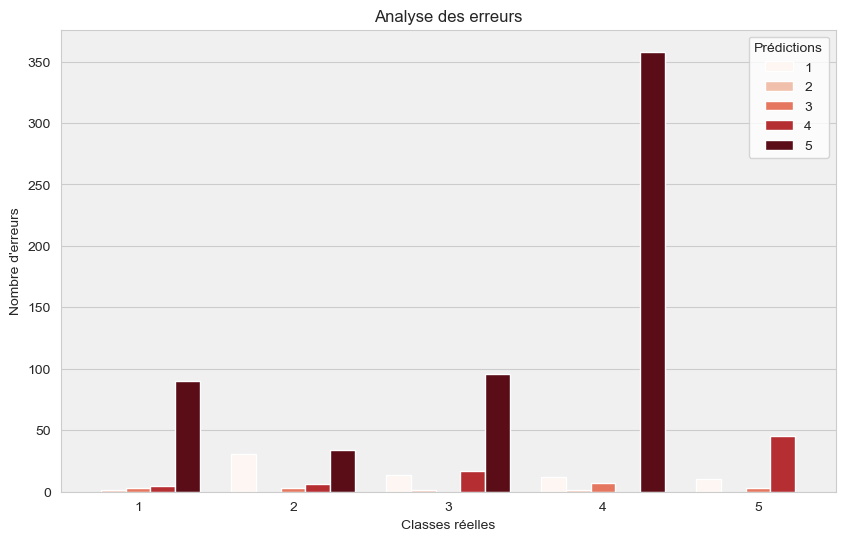

In [ ]:
#___________________Graph des erreurs___________________________________________


# Analyse des erreurs
errors = pd.DataFrame({'Réel': y_val, 'Prédiction': y_val_pred})
errors['Erreur'] = errors['Réel'] != errors['Prédiction']
error_analysis = errors[errors['Erreur']]

print("Analyse des erreurs :")
print(error_analysis)


# Representation graphique des erreurs
plt.figure(figsize=(10, 6))
sns.countplot(x='Réel', hue='Prédiction', data=error_analysis, palette='Reds')
# Ajout un fond gris clair
plt.gca().set_facecolor('#f0f0f0')
plt.title("Analyse des erreurs")
plt.xlabel("Classes réelles")
plt.ylabel("Nombre d'erreurs")
plt.legend(title='Prédictions')
plt.show()

In [ ]:
# #_________________________Interprétabilité du modele__________________________________

# Créer un explainer SHAP


# Préparation de l'explainer SHAP
explainer = shap.TreeExplainer(model)

# Calcul des valeurs SHAP pour l'ensemble de validation
shap_values = explainer.shap_values(X_val_scaled)

# Visualisation des valeurs SHAP
shap.summary_plot(shap_values, X_val_scaled, X_categorielle_encoded_val.columns.tolist() + X_numerique_val.columns.tolist())


In [ ]:
 # Interprétation des résultats : importance des variables

feature_importances = pd.Series(model.feature_importances_, index=X_train_equilibre)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Importance des caractéristiques")
plt.show()

In [15]:
# #Application d'un modèle de classification RandomForestClassifier 
# # cherche les parametre manuellement

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Initialiser le modèle
# #model = RandomForestClassifier(random_state=42)
# model = RandomForestClassifier(n_estimators=50,  # Nombre d'arbres
#                                max_depth=5,     # Profondeur maximale des arbres
#                                min_samples_split=15,  # Nombre minimum d'échantillons requis pour diviser un nœud
#                                min_samples_leaf=10,   # Nombre minimum d'échantillons dans une feuille
#                                random_state=42)

# # Entraînement du modèle
# model.fit(X_train, y_train)

# # Prédictions sur l'ensemble du test
# y_test_pred = model.predict(X_test)

# # Prédictions sur l'ensemble de validation


# # Évaluation du modèle
# print("Classification Report sur l'ensemble de test:\n", classification_report(y_test, y_test_pred))
# print("Accuracy sur l'ensemble de test:", accuracy_score(y_test, y_test_pred))
# cmsm = pd.crosstab(y_test, y_test_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
# display(cmsm)
# print("----------------------------")

# # print("Classification Report sur l'ensemble de validation:\n", classification_report(y_val, y_val_pred))
# # print("Accuracy sur l'ensemble de validation:", accuracy_score(y_val, y_val_pred))

Classification Report sur l'ensemble de test:
               precision    recall  f1-score   support

           0       0.61      0.70      0.65      2465
           1       0.72      0.47      0.56      2464
           2       0.60      0.39      0.47      2465
           3       0.54      0.17      0.26      2465
           4       0.42      0.94      0.58      2465

    accuracy                           0.53     12324
   macro avg       0.58      0.53      0.51     12324
weighted avg       0.58      0.53      0.51     12324

Accuracy sur l'ensemble de test: 0.5345666991236612


Classe prédite,0,1,2,3,4
Classe réelle,,,,,
0,1727,155,140,16,427
1,549,1146,209,75,485
2,397,212,973,183,700
3,131,70,286,417,1561
4,27,10,25,78,2325


----------------------------


In [11]:
#_____________________________analyse des erreurs___________________________________________________

# DataFrame avec les valeurs réelles et prédites
results_df = pd.DataFrame({
    'Classe réelle': y_test,
    'Classe prédite': y_test_pred
})

 #Filtrer les erreurs de prédiction
errors_df = results_df[results_df['Classe réelle'] != results_df['Classe prédite']]

# Afficher les lignes avec des erreurs de prédiction
print("Lignes avec des erreurs de prédiction :")
print(errors_df)

# Ajouter une colonne d'index pour pouvoir joindre avec le DataFrame d'origine
errors_df = errors_df.reset_index()

# Joindre avec le DataFrame d'origine en utilisant l'index ou une clé unique
# Assumons que original_df a un index qui correspond à celui de results_df
# Si ce n'est pas le cas, vous devrez utiliser une colonne clé appropriée.
errors_full_df = errors_df.merge(df, left_on='index', right_index=True, suffixes=('_erreur', '_original'))

# Afficher les lignes avec des erreurs de prédiction complétées par les données d'origine
print("Lignes avec des erreurs de prédiction :")
display(errors_full_df)

Lignes avec des erreurs de prédiction :
        Classe réelle  Classe prédite
29962               3               4
120797              3               4
59420               1               0
27283               4               3
103355              3               4
...               ...             ...
17621               3               4
21988               3               4
31018               4               0
29048               4               3
6837                3               4

[308 rows x 2 columns]
Lignes avec des erreurs de prédiction :


,index,Classe réelle,Classe prédite,Nombre_avis_client,Note_client,Lemmes,Lemmes_titre_commentaire,class_nbavis,nbre_mots,nbre_phrases,class_longueur_mot,class_pt_exclam,class_sentiment,emoticones,sentimentfr,Nombre_Émoticônes
0,29962,3,4,8,3,"['contente', 'achat']","['contente', 'achat']",4-123,4,1,Très court,E0,Positif,Neutre,0.650000,0
3,27283,4,3,1,4,"['satisfait', 'seul', 'point', 'negatif', 'pro...",['satisfait'],1,29,2,moyen,E0,Positif,Neutre,0.083333,0
5,8707,3,4,1,3,"['produit', 'conforme', 'commande', 'expédié',...","['délai', 'expédition', 'respecté']",1,12,2,Court,E0,Positif,Neutre,0.100000,0
6,21884,3,4,9,3,"['produits', 'livrés', 'conform', 'conformes',...","['produits', 'livrés', 'conform', 'conformes']",4-123,46,2,long,E0,Positif,Neutre,0.088500,0
8,21358,4,3,3,4,"['colis', 'rapidement', 'martinique', 'petite'...","['colis', 'rapidement', 'martinique']",2-3,35,4,moyen,E0,Positif,Neutre,0.040000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,17621,3,4,1,3,"['vraiment', 'nickel']",['nickel'],1,3,1,Très court,E1,Neutre,Neutre,0.000000,0
304,21988,3,4,2,3,"['satisfaite', 'materiel', 'souci', 'transport...","['satisfaite', 'materiel']",2-3,31,3,moyen,E0,Positif,Neutre,0.480000,0
305,31018,4,0,1,4,"['fonctionné', 'comme', 'prévu', 'retour', 'fa...","['bonne', 'reprise', 'microsoft', 'surface', '...",1,62,2,long,E0,Positif,Neutre,0.098333,0
306,29048,4,3,5,4,"['attractif', 'bien', 'emballé', 'contre', 'po...","['attractif', 'bien', 'emballé']",4-123,29,1,moyen,E0,Positif,Neutre,0.143125,0
